In [3]:
#import thư viện
#thư viện
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk, ImageOps
import cv2
from keras.utils import img_to_array
import saber as sb
import os
# from google.colab.patches import cv2_imshow

In [4]:
#cắt vùng phiếu
def findFullAnswerSheet(pathImage, width =1830, height =2560):
    img = cv2.imread(pathImage)
    _, countours = sb.getContours(img,minArea=300000)
    points_test_paper = sb.get_4_contour(countours[0][2])
    return sb.wrapImage(img, points_test_paper, width, height)

def get_test_code_image(image):
    height, width, channels = image.shape
    per_width = [0.876, 0.94]
    per_height = (0.0975, 0.298)
    return image[int(per_height[0]*height):int(per_height[1]*height),\
                 int(per_width[0]*width):int(per_width[1]*width)]
def get_student_code_image(image):
    height, width, channels = image.shape
    per_width = (0.727, 0.845)
    per_height = (0.0975, 0.298)
    return image[int(per_height[0]*height):int(per_height[1]*height),\
                 int(per_width[0]*width):int(per_width[1]*width)]
def get_sheet_ans_image(image):
    height, width, channels = image.shape
    per_height = (0.326, 0.945)
    per_width = (0.055, 0.925)
    full_sheet = image[int(per_height[0]*height):int(per_height[1]*height),\
                 int(per_width[0]*width):int(per_width[1]*width)]
    return full_sheet
def get_part_sheet_ans_image(image,dis=10):
    height, width, channels = image.shape
    dis = 0.03562 * width
    A, B = image[:,:int(round((width+dis)/2 - dis,0))], image[:,int(round((width+dis)/2,0)):]
    A1,A2 = A[:,:int(round((A.shape[1]+dis)/2 - dis,0))], A[:,int(round((A.shape[1]+dis)/2,0)):]
    B1,B2 = B[:,:int(round((B.shape[1]+dis)/2 - dis,0))], B[:,int(round((B.shape[1]+dis)/2,0)):]
    return [A1,A2,B1,B2]

In [5]:
def get_student_code(img_sbd, thresh_value = 150):
    # Xử lý ảnh
    gray = cv2.cvtColor(img_sbd, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Xoá viền
    kernel = np.ones((5,5))
    imgDilation = cv2.dilate(blur, kernel, iterations = 2)
    # Phóng to phần tô màu
    erosion = cv2.erode(imgDilation, kernel, iterations = 2)
    # Chuyển thành giá trị nhị phân, giá trị nào dưới 100 về 0, ngược lại 255 (đen và trắng)
    _, thresh = cv2.threshold(erosion, thresh_value, 255, cv2.THRESH_BINARY)

    # cv2_imshow(thresh)
    column_width = img_sbd.shape[1] // 6
    bubble_positions = [int(i*(img_sbd.shape[0]//10)) for i in range(11)]

    student_ID = ""
    for i in range(6): # Có 6 cột số báo danh
        column = thresh[:,i*column_width:(i+1)*column_width]
        selected_number = None
        min_mean = float('inf')

        for pos in range (10): # Có 10 dòng từ 0-9
            start, end = bubble_positions[pos], bubble_positions[pos+1]
            mean_value = np.mean(column[start:end, :])
            # Tìm giá trị trung bình nhỏ nhất
            # Nhỏ nhất là chứa nhiều phần tử màu đen nhất, tức chọn ô này
            if mean_value < min_mean:
                min_mean = mean_value
                selected_number = pos
        student_ID += str(selected_number)
    return student_ID

def get_test_code(img, thresh_value = 150):
    # Xử lý ảnh
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Xoá viền
    kernel = np.ones((5,5))
    imgDilation = cv2.dilate(blur, kernel, iterations = 2)
    # Phóng to phần tô màu
    erosion = cv2.erode(imgDilation, kernel, iterations = 2)
    # Chuyển thành giá trị nhị phân, giá trị nào dưới 100 về 0, ngược lại 255 (đen và trắng)
    _, thresh = cv2.threshold(erosion, thresh_value, 255, cv2.THRESH_BINARY)
    # cv2_imshow(thresh)
    column_width = img.shape[1] // 3
    bubble_positions = [int(i*(img.shape[0]//10)) for i in range(11)]

    test_ID = ""
    for i in range(3): # Có 6 cột số báo danh
        column = thresh[:,i*column_width:(i+1)*column_width]
        selected_number = None
        min_mean = float('inf')

        for pos in range (10): # Có 10 dòng từ 0-9
            start, end = bubble_positions[pos], bubble_positions[pos+1]
            mean_value = np.mean(column[start:end, :])
            # Tìm giá trị trung bình nhỏ nhất
            # Nhỏ nhất là chứa nhiều phần tử màu đen nhất, tức chọn ô này
            if mean_value < min_mean:
                min_mean = mean_value
                selected_number = pos
        test_ID += str(selected_number)
    return test_ID

In [11]:
def get_my_ans(image_ans, ANSWER_KEY, thresh_value = 150, limit_value = 240, start_ = 55):
    translate = {"A": 0, "B": 1, "C": 2, "D": 3}
    revert_translate = {0: "A", 1: "B", 2: "C", 3: "D", -1: "N"}
    img = image_ans[:,start_:]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # Xoá viền
    kernel = np.ones((5,5))
    imgDilation = cv2.dilate(blur, kernel, iterations = 2)
    # Phóng to phần tô màu
    erosion = cv2.erode(imgDilation, kernel, iterations = 2)
    # Chuyển thành giá trị nhị phân, giá trị nào dưới 100 về 0, ngược lại 255 (đen và trắng)
    _, thresh = cv2.threshold(erosion, thresh_value, 255, cv2.THRESH_BINARY)

    # plt.imshow(img_cnts)

    ans_char = ['A','B','C','D']
    height_sub = img.shape[0] // 6
    n_part, n_questions = 6,5
    pad = 5
    my_answers = []

    for i_part in range(n_part):
        sub_img = thresh[height_sub*i_part+pad*3:height_sub*(i_part+1)-pad*2,pad:-pad]

        bubble_positions = [int(idx*(sub_img.shape[0]//n_questions)) for idx in range(n_questions+1)]
        for j in range(n_questions):
            start, end = bubble_positions[j], bubble_positions[j+1]
            row_1_question = sub_img[start:end,:]

            min_mean = float('inf')
            selected_ans = None
            width_sub = row_1_question.shape[1] // 4
            for i_ans in range(4):
                mean_value = np.mean(row_1_question[:,i_ans*width_sub:(i_ans+1)*width_sub])
                # print(mean_value)
                # Nếu không chọn đáp án, sẽ có limit_value chặn
                if mean_value < limit_value and mean_value < min_mean:
                    min_mean = mean_value
                    selected_ans = ans_char[i_ans]
            if selected_ans is not None:
                my_answers.append(selected_ans)
            else:
                my_answers.append("-")
    r = 15
    for part in range(n_part):
        start_h, start_w = height_sub * part + 45, 35 + start_
        try:
            for quest in range(n_questions):
                idx = part*n_questions+quest
                s_w = start_w + 74* translate[ANSWER_KEY[idx]]
                if my_answers[idx] == ANSWER_KEY[idx]:
                    cv2.circle(image_ans, (s_w, start_h), r, (0, 255, 0), 3)
                else: 
                    w_wrong_ans = start_w + 74 * translate[my_answers[idx]]
                    cv2.circle(image_ans, (w_wrong_ans, start_h), r, (0, 0, 255), 3)
                    cv2.circle(image_ans, (s_w, start_h), r, (255, 0, 0), 3)
                start_h += 45
        except:
            break
    return my_answers

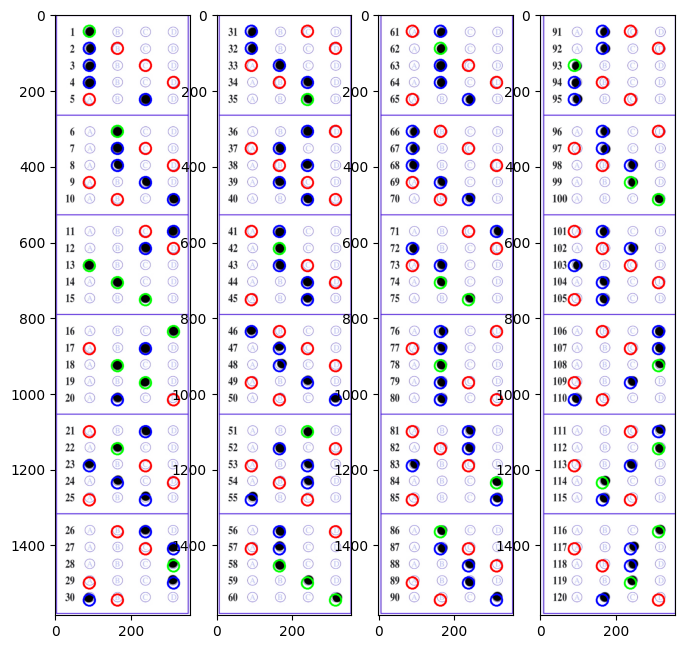

Mã sinh viên:	150947 
Mã đề thi:	284
Điểm:		2.4


In [15]:
# Lưu trữ các đáp án đúng
# ANSWER_KEY = [
#     "A", "B", "C", "D", "A", "C", "D", "B", "A", "C", "A", "B", "C", "D",
#     "A", "A", "B", "C", "D", "A", "A", "B", "C", "D", "A", "A", "B", "C",
#     "D", "A", "A", "B", "C", "D", "A", "C", "D", "B", "A", "C", "A", "B",
#     "C", "D", "A", "A", "B", "C", "D", "A", "A", "B", "C", "D", "A", "A",
#     "B", "C", "D", "A", "A", "B", "C", "D", "A", "C", "D", "B", "A", "C",
#     "A", "B", "C", "D", "A", "A", "B", "C", "D", "A", "A", "B", "C", "D",
#     "A", "A", "B", "C", "D", "D", "A", "B", "C", "D", "A", "C", "D", "B",
#     "A", "C", "A", "B", "C", "D", "A", "A", "B", "C", "D", "A", "A", "B",
#     "C", "D", "A", "A", "B", "C", "D", "A"
# ]
ANS_KEY = ['A','B','C','D']*30
# Đọc ảnh
width,heigh = 1830,2560

image = cv2.imread("img/1.jpg")
image = cv2.resize(image, (width, heigh))
# image = findFullAnswerSheet("2.jpg")
# custom_width = 400
# custom_height = 600

# cv2.namedWindow('IMG', cv2.WINDOW_NORMAL)
# cv2.resizeWindow('IMG', custom_width, custom_height)

# cv2.imshow("IMG",image)


#vùng ảnh số báo danh
anh_sbd = get_student_code_image(image)
#vùng ảnh mã đề thi
anh_mdt = get_test_code_image(image)

# cv2.imshow("IMG",anh_sbd)
# cv2.imshow("IMG",anh_mdt)
# 4 ảnh, mỗi ản 30 câu
lst_sheet_ans = get_part_sheet_ans_image(get_sheet_ans_image(image))


NUM_QUESTIONS = 50

student_ID = get_student_code(anh_sbd)
test_ID = get_test_code(anh_mdt)

all_answer_key = []
for i in range(4):
    my_ans = get_my_ans(lst_sheet_ans[i],ANS_KEY[i*30:i*30+30])
    # print(my_ans)
    for ans in my_ans:
        all_answer_key.append(ans)
all_answer_key = np.array(all_answer_key)
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(1,4,i+1), plt.imshow(lst_sheet_ans[i])
plt.show()
score = sum(all_answer_key[:NUM_QUESTIONS] == ANS_KEY[:NUM_QUESTIONS])/NUM_QUESTIONS * 10

print(f"Mã sinh viên:\t{student_ID}", f"\nMã đề thi:\t{test_ID}")
print(f"Điểm:\t\t{score}")

# cv2.waitKey(5000)
# cv2.destroyAllWindows()


In [18]:
NUM_QUESTIONS = 120

show_w, show_h = 600,400
my_w = tk.Tk()
my_w.geometry("800x600")  # Size of the window
my_w.title('Predict!')
my_font1=('times', 18, 'bold')
l1 = tk.Label(my_w,text='Upload image',width=30,font=my_font1)
l1.grid(row=1,column=1)
b1 = tk.Button(my_w, text='Select File',
   width=20,command = lambda:upload_file())
b1.grid(row=2,column=1)

def button_click():
    global NUM_QUESTIONS
    try:
        NUM_QUESTIONS = int(entry.get())  # Lấy giá trị nhập từ một Entry widget và chuyển nó thành số nguyên
        # Sử dụng giá trị số 'num' ở đây
    except ValueError:
        print("Không phải số nguyên")

entry = tk.Entry(my_w, width=20)
entry.grid(row=1, column=0)

button = tk.Button(
    my_w,
    text="Predict_nhap",
    width=20,
    command = lambda: predict_nhap(ANS_KEY)
)
button.grid(row=10,column=1)
b2 = tk.Button(
    my_w,
    text="Predict_chup",
    width=20,
    command = lambda: predict_chup(ANS_KEY)
)
b2.grid(row=30,column=1)

b3 = tk.Button(
    my_w,
    text="num_ans",
    width=20,
    command = button_click
)
b3.grid(row=50,column=1)

l2 = tk.Label(my_w,text="Score",width=30,font=my_font1)
l2.grid(row=1,column=2)


def upload_file():
    global file_path
    f_types = [('Image Files', '*.jpg;*.jpeg;*.png')]
    file_path = filedialog.askopenfilename(filetypes=f_types)

    image = Image.open(file_path)
    image = image.resize((300,300))
    photo = ImageTk.PhotoImage(image)

    b2 = tk.Button(my_w,image=photo)
    b2.photo = photo
    b2.grid(row=3,column=1)

def predict_nhap(ANS_KEY):
    global NUM_QUESTIONS
    global file_path
    image = cv2.imread(file_path)
    image = cv2.resize(image, (1830, 2560))
    anh_sbd = get_student_code_image(image)
    anh_mdt = get_test_code_image(image)
    lst_sheet_ans = get_part_sheet_ans_image(get_sheet_ans_image(image))
    student_ID = get_student_code(anh_sbd)
    test_ID = get_test_code(anh_mdt)

    all_answer_key = []
    for i in range(4):
        my_ans = get_my_ans(lst_sheet_ans[i],ANS_KEY[i*30:(i+1)*30])
        # print(my_ans)
        for ans in my_ans:
            all_answer_key.append(ans)
    all_answer_key = np.array(all_answer_key)

    score = round((sum(all_answer_key[:NUM_QUESTIONS] == ANS_KEY[:NUM_QUESTIONS])/NUM_QUESTIONS) * 10,3)


    string_sbd = ''.join(map(str,student_ID))
    string_mdt = ''.join(map(str,test_ID))

    cv2.putText(image, "Score : " + str(score), (50, 80),
            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    cv2.putText(image, "SBD : " + string_sbd, (50, 150),
            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    cv2.putText(image, "MDT : " + string_mdt, (50, 210),
            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    imS = cv2.resize(image, (show_h, show_w))

    # Tạo đối tượng Label để hiển thị hình ảnh
    image_label = tk.Label(my_w)
    image_label.grid(row=3, column=2)

    # Chuyển đổi hình ảnh OpenCV sang định dạng hình ảnh Tkinter
    image = cv2.cvtColor(imS, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    photo = ImageTk.PhotoImage(image)

    # Gắn hình ảnh vào Label
    image_label.configure(image=photo)
    image_label.image = photo

    file_name = "score.txt"
    with open(file_name, "a") as file:
        file.write(f"{student_ID},{test_ID},{score}\n")

    result_str = "Điểm: " + str(score)
    sbd_str = "SBD: " + str(student_ID)
    mdt_str = "MDT: " + str(test_ID)
    combined_str = result_str + " | " + sbd_str + " | " + mdt_str

    l3 = tk.Label(my_w, text=combined_str, width=80, font=my_font1)
    l3.grid(row=2,column=2)

def predict_chup(ANS_KEY):
    global NUM_QUESTIONS
    print(NUM_QUESTIONS)
    width,heigh = 1830,2560
    global file_path
    image = findFullAnswerSheet(file_path)
    anh_sbd = get_student_code_image(image)
    anh_mdt = get_test_code_image(image)
    lst_sheet_ans = get_part_sheet_ans_image(get_sheet_ans_image(image))
    student_ID = get_student_code(anh_sbd)
    test_ID = get_test_code(anh_mdt)

    all_answer_key = []
    for i in range(4):
        my_ans = get_my_ans(lst_sheet_ans[i],ANS_KEY[i*30:(i+1)*30])
        # print(my_ans)
        for ans in my_ans:
            all_answer_key.append(ans)
    all_answer_key = np.array(all_answer_key)



    score = round((sum(all_answer_key[:NUM_QUESTIONS] == ANS_KEY[:NUM_QUESTIONS])/NUM_QUESTIONS) * 10,3)


    string_sbd = ''.join(map(str,student_ID))
    string_mdt = ''.join(map(str,test_ID))

    cv2.putText(image, "Score : " + str(score), (50, 80),
            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    cv2.putText(image, "SBD : " + string_sbd, (50, 150),
            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    cv2.putText(image, "MDT : " + string_mdt, (50, 210),
            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3)
    imS = cv2.resize(image, (show_h, show_w))

    # Tạo đối tượng Label để hiển thị hình ảnh
    image_label = tk.Label(my_w)
    image_label.grid(row=3, column=2)

    # Chuyển đổi hình ảnh OpenCV sang định dạng hình ảnh Tkinter
    image = cv2.cvtColor(imS, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    photo = ImageTk.PhotoImage(image)

    # Gắn hình ảnh vào Label
    image_label.configure(image=photo)
    image_label.image = photo

    file_name = "score.txt"
    with open(file_name, "a") as file:
        file.write(f"{student_ID},{test_ID},{score}\n")
    result_str = "Điểm: " + str(score)
    sbd_str = "SBD: " + str(student_ID)
    mdt_str = "MDT: " + str(test_ID)
    combined_str = result_str + " | " + sbd_str + " | " + mdt_str

    l3 = tk.Label(my_w, text=combined_str, width=80, font=my_font1)
    l3.grid(row=2,column=2)

my_w.mainloop()

40
